## Using SHAP to get the feature contirbution to target variable

### Import libraries

In [1]:
import shap
import pandas as pd 
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


### Import features/columns present in survey

In [2]:
from constants import (village_info_col,
                        questionare_col,
                        other_ques_col,
                        option_ques,
                        categorical_ques,
                        regression_feat,
                        categorical_feat,
                        index_col,
                        target_col)

### Load data into dataframe

In [3]:
fans_survey_data = 'covid19-data/Panchayat Survey-FaNS-MGSA(10.05.21).xlsx'
dmks_survey_Dat = 'covid19-data/Panchayat Survey_ DMKS (10.05.21).xlsx'
dmks_sheet_name = fans_sheet_name = 'Raw Data'

In [4]:
fans_df = pd.read_excel(fans_survey_data, sheet_name = fans_sheet_name)

#fans_df = pd.read_excel(dmks_survey_Dat, sheet_name = dmks_sheet_name)
print(len(fans_df))
#fans_df.columns
print(len(fans_df.Identifier.unique()))

363
198


Index(['Identifier', 'Repeat no', 'Display Name', 'Device identifier',
       'Instance', 'Submission Date', 'Duration', 'Form version',
       'Block - Panchayat - Volunteer - Block',
       'Block - Panchayat - Volunteer - Gram Panchayat',
       'How many villages are there in your panchayat?',
       'Have you maintained a record of the Migrant Community who returned during lockdown?',
       'Name of Village', 'Total number of Migrant Families who have returned',
       'Females', 'Males', 'Children (0-6 years)',
       'Total Number of COVID Infected',
       'How many COVID-19 testing centres or treatment centres are there in your Panchayat?',
       'Are you aware of various Government Schemes for Migrant Labours who have returned?',
       'Tick the schemes that you are aware of',
       '--OPTION--|Pradhanmantri Kisan Samman Yojana',
       '--OPTION--|Pradhanmantri Jan-Dhan Khata yojana',
       '--OPTION--|Pradhanmantri Gareen Ann Kalyan Yojana',
       '--OPTION--|Pradhanm

### Data Cleaning and Data Preparation

In [5]:
# Filter by Repeat No. since data is missing for repeat no other than 1.
fans_df = fans_df[fans_df["Repeat no"] ==1]

#Drop col other than regression_feat, categorical_feat, index_col
query_df = fans_df[[index_col] + regression_feat + categorical_feat ]

# Convert cols in option_ques from nan into 0
for col in categorical_feat:
    query_df[col] = query_df[col].fillna(0)

How many villages are there in your panchayat?
[3. 1. 4. 2. 5. 6. 7. 9.]
--------------------------
Total number of Migrant Families who have returned
[ 30   2  10 110  91  45  12  32  54  28  11  38  44  31 190 169  15   1
  25  18  35  24  46  43  34  16  21  42  80  20  40  47  19 115  17  33
  37  65  22  50  41  13  29  26  55  82  49   6  66 100   3  75  62  70
  60  14   5  27  36  71   0  48  63  23  68  90  52]
--------------------------
Females
[ 15   1   0 275  20   2  40  32  56   9   3  99   5   8  34  10  11  30
  23 125   6   4  42  41   7  13  70  36  35  22  12  31  14  50  17  24
  55  19 109  21  54  26  16  18  25  71  38  33  59  27  64]
--------------------------
Males
[ 15   1  10 320  71  45  12  51  48  52  14  11  30  41 180 149   2  40
  13 128  18  35  19  43  24 110  42 135  74  32   6  78   5  38  34 176
  50  27  20 100  93  77  31  29  25  57  23 148  46  33  17  16  22  62
  28  54 132 103   8  21  80   4  90   9  70  83  47   0  67  60  55  39
   7  91


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Data Transformation

In [6]:
# Transformation to feed into regressor
answer_map = {'Yes': 1, 'No': 0, 1. : 1, 0.:0}

for col in categorical_feat:
    query_df[col] = query_df[col].map(answer_map)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
for col in query_df.columns[1:]:
    print(col)
    print(query_df[col].unique())
    print('--------------------------')

How many villages are there in your panchayat?
[3. 1. 4. 2. 5. 6. 7. 9.]
--------------------------
Total number of Migrant Families who have returned
[ 30   2  10 110  91  45  12  32  54  28  11  38  44  31 190 169  15   1
  25  18  35  24  46  43  34  16  21  42  80  20  40  47  19 115  17  33
  37  65  22  50  41  13  29  26  55  82  49   6  66 100   3  75  62  70
  60  14   5  27  36  71   0  48  63  23  68  90  52]
--------------------------
Females
[ 15   1   0 275  20   2  40  32  56   9   3  99   5   8  34  10  11  30
  23 125   6   4  42  41   7  13  70  36  35  22  12  31  14  50  17  24
  55  19 109  21  54  26  16  18  25  71  38  33  59  27  64]
--------------------------
Males
[ 15   1  10 320  71  45  12  51  48  52  14  11  30  41 180 149   2  40
  13 128  18  35  19  43  24 110  42 135  74  32   6  78   5  38  34 176
  50  27  20 100  93  77  31  29  25  57  23 148  46  33  17  16  22  62
  28  54 132 103   8  21  80   4  90   9  70  83  47   0  67  60  55  39
   7  91

In [8]:
assert (len(query_df[[index_col]]) == len(query_df[index_col].unique()))

In [9]:
query_df.set_index(index_col, inplace=True)

In [10]:
X, y = query_df.drop([target_col], axis=1), query_df[target_col]

In [11]:
X.head(3)

,How many villages are there in your panchayat?,Total number of Migrant Families who have returned,Females,Males,Children (0-6 years),How many COVID-19 testing centres or treatment centres are there in your Panchayat?,--OPTION--|Pradhanmantri Kisan Samman Yojana,--OPTION--|Pradhanmantri Jan-Dhan Khata yojana,--OPTION--|Pradhanmantri Gareen Ann Kalyan Yojana,--OPTION--|Pradhanmantri Ujjwala Yojana,...,--OPTION--|Water shed,--OPTION--|Small enterprises for agriculture-related work,--OPTION--|Help for an awareness campaign,--OPTION--|Skill development training,--OPTION--|Seeds and Guidance for Nutrition Garden,--OPTION--|Schemes related information and help,Have you maintained a record of the Migrant Community who returned during lockdown?,Are you aware of various Government Schemes for Migrant Labours who have returned?,"Are milk, vegetables and daily use essentials supply easily available in your Panchayat?","We, under COVID-19 response program, will work for livelihood support to returned migrant labour in your panchayat, in which your support is also required. Do you agree?"
Identifier,,,,,,,,,,,,,,,,,,,,,
r9dr-bmkk-renc,3.0,30,15,15,8,3.0,1,0,0,0,...,1,0,0,1,1,0,1,1,1,1
5nrm-wje4-84c5,3.0,2,1,1,0,2.0,1,0,1,1,...,1,0,0,0,1,0,1,1,1,1
wmcs-2aap-bfgg,1.0,10,0,10,1,0.0,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1


In [12]:
y.head(3)

Identifier
r9dr-bmkk-renc    10
5nrm-wje4-84c5     0
wmcs-2aap-bfgg     0
Name: Total Number of COVID Infected, dtype: int64

### Split the data in training and test set

In [13]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

### Random Forest Model

In [14]:
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [15]:
rf_train = rf_reg.score(Xtrain, ytrain)
rf_cv = cross_val_score(rf_reg, Xtrain, ytrain, cv=5).mean()
rf_test = rf_reg.score(Xtest, ytest)
print('Evaluation of the Random Forest performance\n')
print(f'Training score: {rf_train.round(4)}')
print(f'Cross validation score: {rf_cv.round(4)}')
print(f'Test score: {rf_test.round(4)}')

Evaluation of the Random Forest performance

Training score: 0.8846
Cross validation score: 0.2058
Test score: -0.5995


### SHAP values

In [16]:
# Initialize JavaScript visualization
shap.initjs()

In [17]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_reg)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [18]:
# shap force plot for the first prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [19]:
# SHAP values for all predictions
shap.force_plot(explainer.expected_value, shap_values, X)

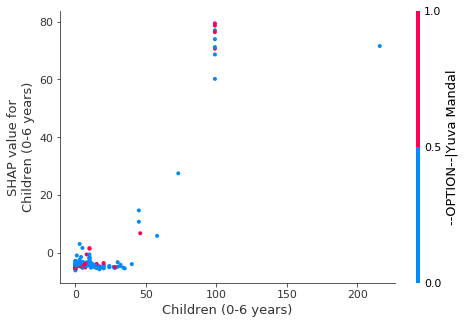

In [20]:
# Effect of a single feature on the shap value,and automatically selected other feature to show dependence 
shap.dependence_plot("Children (0-6 years)", shap_values, X)

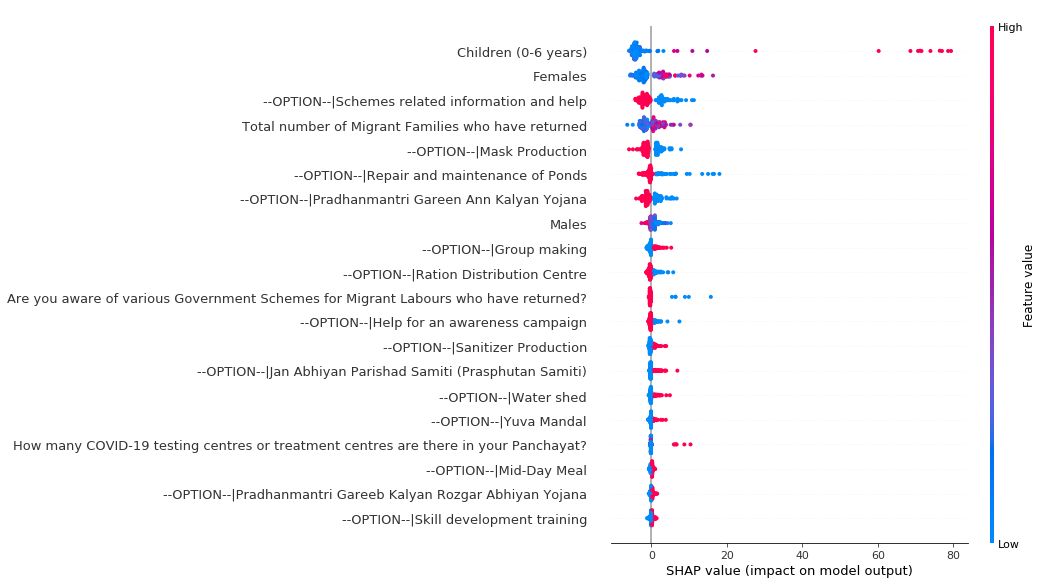

In [21]:
# See how every feaure contributes to the model output
shap.summary_plot(shap_values, X)

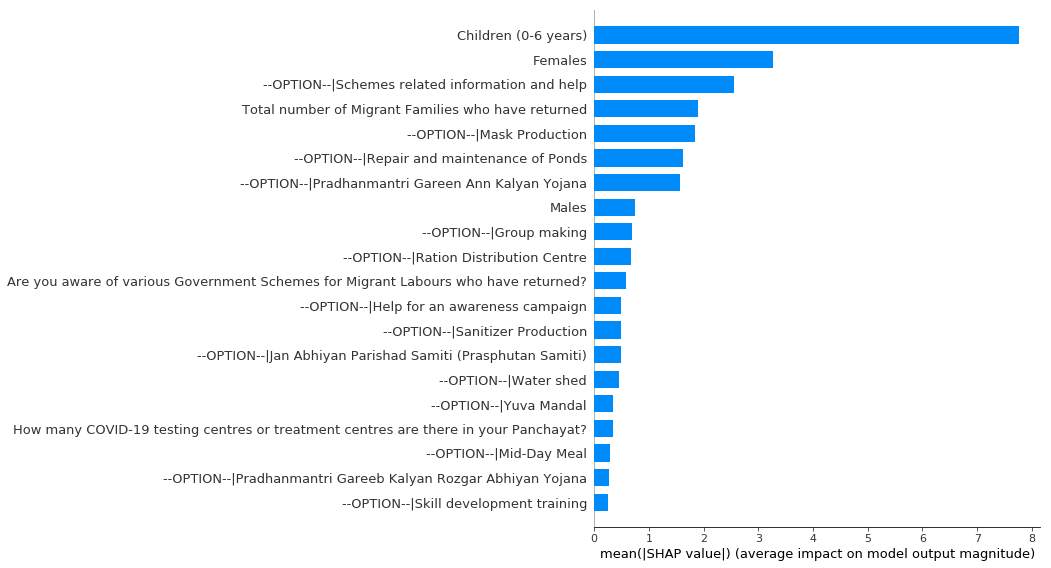

In [22]:
shap.summary_plot(shap_values, X, plot_type="bar")